In [2]:
## Author: Aloi Davide - PhD student - University of Birmingham 

# Data: MRI (T1s) scans with different brain tumors, downloaded from
# https://figshare.com/articles/dataset/brain_tumor_dataset/1512427. 
# There are 3 types of tumors: meningiomas (ID = 1), gliomas (ID = 2), pituitary tumors (ID = 3).

# Files are in .mat format so we'll have to use mat73 to read their content and convert it 
# to png.

import os 
from fastai.vision.all import *
import mat73 

# Path to the tumor dataset (sub-folder "dataset" containing the .mat files)
path = os.path.join('D:\\deep_learning_project\\project\\tumor_dataset\\dataset')
# Path where we will save the images in PNG format
path_images = os.path.join('C:\\Users\\davide\\Documents\\GitHub\\idmlp_project\\data\\')

In [43]:
# Creating folder for the PNG files
isExist = os.path.exists(os.path.join(path_images))

if not isExist:
  print('Creating all directories to store the data')
  os.makedirs(path_images)
  os.makedirs(os.path.join(path_images, 'glioma'))
  os.makedirs(os.path.join(path_images, 'meningioma'))
  os.makedirs(os.path.join(path_images, 'pituitary'))

There are 233 patients with brain tumors in the dataset.
82 are meningiomas, 89 are gliomas, 62 are pituitary tumors.


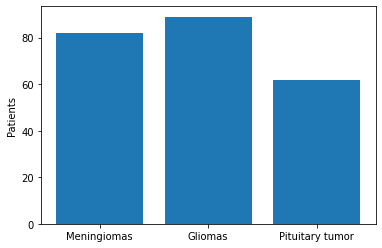

In [13]:
# SKIP THIS IF YOU HAVE EXTRACTED THE MAT FILES ALREADY
from PIL import Image

# Extracting .mat files and displaying some info about the dataset
# This might take a couple of minutes

PIDs = []
tumor_type = []
for file in os.listdir(path):
    data = mat73.loadmat(os.path.join(path, file))
    im = Image.fromarray((data['cjdata']['image']/data['cjdata']['image'].max()) * 255)

    # Reading the label from the .mat file
    if int(data['cjdata']['label']) == 1:
        label = 'meningioma'
    elif int(data['cjdata']['label']) == 2:
        label = 'glioma'
    else:
        label = 'pituitary'

    # converting .mat file into a .png file and saving it
    im = im.convert('P')
    im.save(os.path.join('data', label, file.split('.')[0] + '.png'))
    
    # Displaying some descriptive statistics of the dataset 
    # nb there is more than 1 slice per patients
    if not data['cjdata']['PID'] in PIDs:
        PIDs.append(data['cjdata']['PID'])
        tumor_type.append(int(data['cjdata']['label']))

# Displaying some descriptive statistics of the dataset #import matplotlib.pyplot as plt
print(f'There are {len(PIDs)} patients with brain tumors in the dataset.')
print(f'{tumor_type.count(1)} are meningiomas, {tumor_type.count(2)} are gliomas, {tumor_type.count(3)} are pituitary tumors.')

fig = plt.figure()
plt.bar(['Meningiomas', 'Gliomas', 'Pituitary tumor'],
        [tumor_type.count(1), tumor_type.count(2), tumor_type.count(3)])
plt.ylabel('Patients')
plt.show()

In [4]:
# Let us first load the dataset that we created above.
# The dataset is divided into 3 different tumors: Gliomas, Pituitary tumors and Meningiomas.
data = ImageDataLoaders.from_folder(path_images, valid_pct = 0.2, item_tfms=Resize(224), shuffle = True)
# we'll use 20% of the dataset for validation in each epoch. 

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


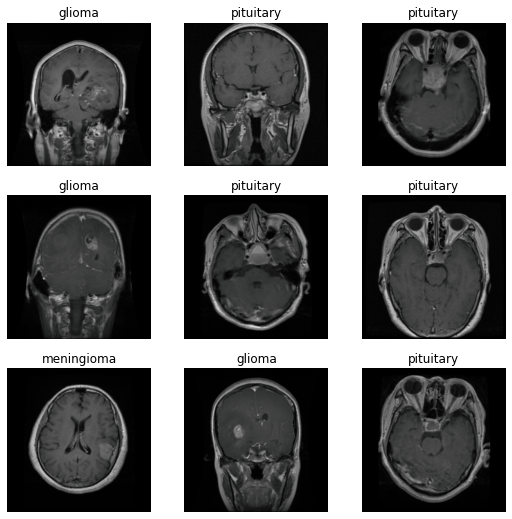

In [39]:
# Now we can show an example of our data. Let's show a batch. 
data.show_batch()

SuggestedLRs(valley=0.0010000000474974513)

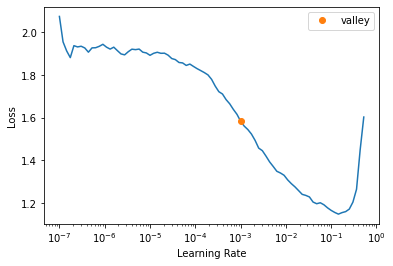

In [7]:
# Let us first find an optimal learning rate 
learn = cnn_learner(data, resnet34, metrics=accuracy)
learn.lr_find()

In [9]:
# We're gonna use the value "valley" as learning rate. This is the poin 
# in the middle of the sharpest downward slope.
# We'll use 10 epochs.

n_epochs = 10
learn.fine_tune(n_epochs, 1e-03) # using the OLR found above

# We can then save the model now
learn.save('model')

epoch,train_loss,valid_loss,accuracy,time
0,0.995284,0.931127,0.691176,07:11


epoch,train_loss,valid_loss,accuracy,time
0,0.401213,0.302431,0.910131,08:39
1,0.244815,0.261941,0.921569,08:37
2,0.147125,0.251872,0.923203,08:33
3,0.095046,0.199203,0.946078,08:40
4,0.060223,0.203613,0.949346,08:28
5,0.037135,0.169092,0.955882,08:28
6,0.023385,0.164369,0.950980,08:40
7,0.013314,0.172732,0.952614,08:50
8,0.007958,0.157361,0.960784,08:39
9,0.005288,0.162432,0.959150,08:33


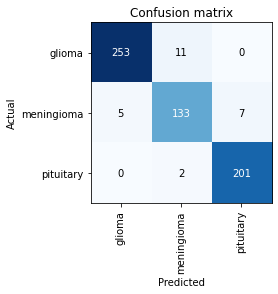

In [36]:
# Let's investigate our confusion matrix
interp = ClassificationInterpretation.from_learner(learn) # Interpretation methods for classification models.
interp.plot_confusion_matrix()

In [44]:
# We can print the most confused pairs
interp.most_confused(min_val=2)

[('glioma', 'meningioma', 11),
 ('meningioma', 'pituitary', 7),
 ('meningioma', 'glioma', 5),
 ('pituitary', 'meningioma', 2)]

In [ ]:
# It looks like the most confused pair is glioma --> meningioma. It makes sense that a CNN is better
# at identifying pituitary tumors, as these have less variability in terms of neuroanatomical characteristics 
# (i.e. the location / size). 

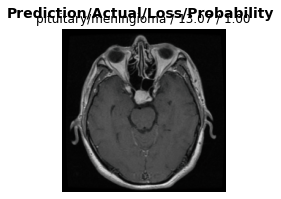

In [16]:
# The last fastai has a bug I believe, and it can only show the first loss of the top lossess
interp.plot_top_losses(1)